In [1]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import warnings
import joblib

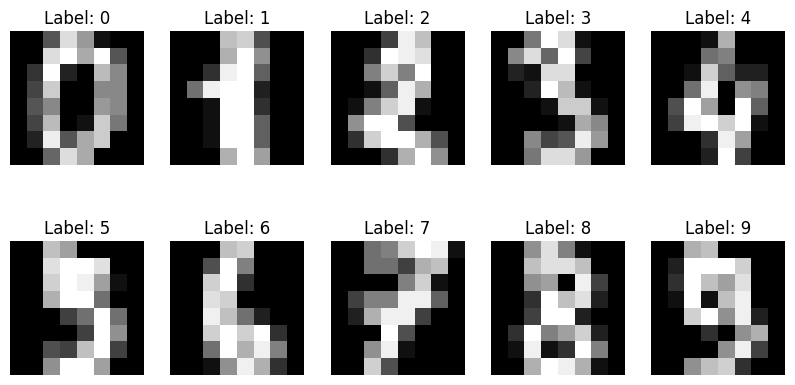

In [2]:
# Load the MNIST dataset
digits = datasets.load_digits()

# Plot some images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.show()

In [3]:
# Flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into training , validation and test sets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [4]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (1077, 64)
y_train shape (1077,)
X_test shape (360, 64)
y_test shape (360,)


In [5]:
# Train linear SVM model
clf = svm.LinearSVC()
clf.fit(X_train, y_train)

# Print summary of SVM model
print(clf)

LinearSVC()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
# Evaluate the SVM model on train set
train_accuracy = clf.score(X_train, y_train)
print('Train accuracy:', train_accuracy)

Train accuracy: 0.9916434540389972


In [7]:
# Convert SVM decision function to Keras model
keras_model = Sequential([
    Dense(units=len(set(y_train)), activation='softmax', input_shape=X_train.shape[1:])
])
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape the weights to match the input shape of the Dense layer
weights = np.transpose(clf.coef_)
bias = -clf.intercept_

# Set the weights and bias to the Keras model
keras_model.layers[0].set_weights([weights, bias])

In [9]:
# Evaluate the Keras model on train set
train_loss, train_accuracy = keras_model.evaluate(X_train, y_train)
print('Train loss:', train_loss)
print('Train accuracy:', train_accuracy)

34/34 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.9285
Train loss: 0.20713907480239868
Train accuracy: 0.9285051226615906


In [10]:
# Evaluate the Keras model on validation set
val_loss, val_accuracy = keras_model.evaluate(X_val, y_val)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)

12/12 [==============================] - 0s 5ms/step - loss: 0.3473 - accuracy: 0.8750
Validation loss: 0.3472749888896942
Validation accuracy: 0.875


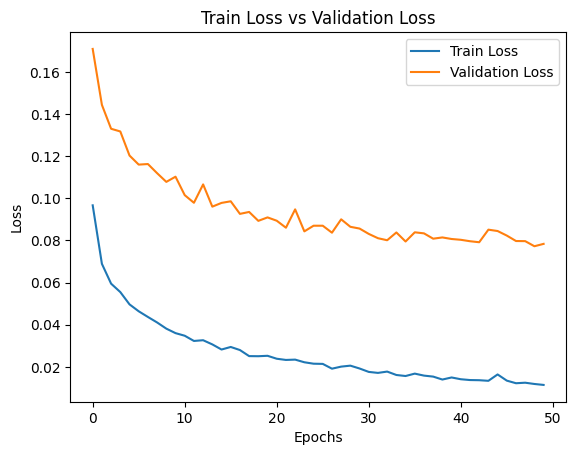

In [11]:
# Plotting train loss vs validation loss
history = keras_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

In [12]:
# Evaluate the Keras model on test set
test_loss, test_accuracy = keras_model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

12/12 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.9639
Test loss: 0.15314096212387085
Test accuracy: 0.9638888835906982


12/12 [==============================] - 0s 1ms/step


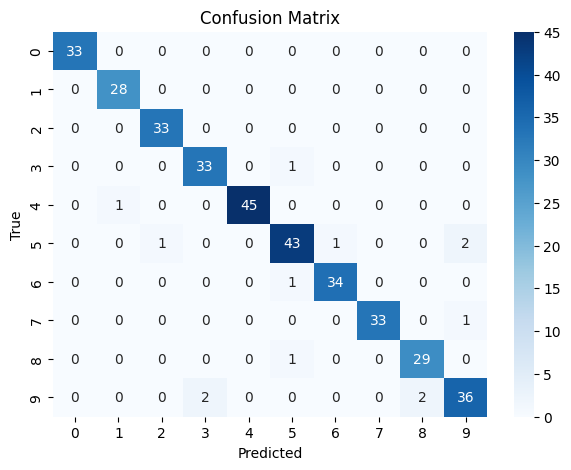

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = keras_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Convert Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('svm_mnist.tflite', 'wb') as f:
    f.write(tflite_model)

In [16]:
# Save the trained model
joblib.dump(clf, 'svm_model.pkl')

['svm_model.pkl']

In [17]:
import joblib
import numpy as np

# Load the trained SVM model
svm = joblib.load('svm_model.pkl')

# Extract model parameters
svm_weights = svm.coef_
svm_bias = svm.intercept_

In [18]:
# Save model parameters to a header file
with open('svm_model.h', 'w') as f:
    f.write("#ifndef SVM_MODEL_H\n")
    f.write("#define SVM_MODEL_H\n\n")
    f.write("extern const float svm_model_weights[NUM_CLASSES][NUM_FEATURES];\n")
    f.write("extern const float svm_model_bias[NUM_CLASSES];\n\n")
    f.write("#endif /* SVM_MODEL_H */\n\n")

    f.write("const float svm_model_weights[NUM_CLASSES][NUM_FEATURES] = {\n")
    for row in svm_weights:
        f.write("    {")
        for i, val in enumerate(row):
            f.write("{:.8f}".format(val))
            if i != len(row) - 1:
                f.write(", ")
        f.write("},\n")
    f.write("};\n\n")

    f.write("const float svm_model_bias[NUM_CLASSES] = {")
    for i, val in enumerate(svm_bias):
        f.write("{:.8f}".format(val))
        if i != len(svm_bias) - 1:
            f.write(", ")
    f.write("};\n")